Algoritmos

In [1]:
#The first byte of the record stores the size.
#The string values are encoded using utf-8,
#which can use more bytes than the number of
#characters of the string.
class Record:
  def __init__(self, record_size, value=""):
    self.byte_array = bytearray([0] * record_size)
    self.write(value)

  # creates a record from a bytearray
  def create(record_size, byte_array):
    string_bytes = byte_array[1:1+byte_array[0]]
    return Record(record_size, string_bytes.decode('utf-8'))

  def write(self, value):
    if(not isinstance(value, str)):
       raise TypeError(f"The value must be str!")

    string_bytes = value.encode('utf-8')

    if (1+len(string_bytes))> len(self.byte_array):
      raise ValueError(f"Record overflow!")

    self.byte_array[0] = len(string_bytes)
    self.byte_array[1:1+len(string_bytes)] = string_bytes

  def read(self):
    string_bytes = self.byte_array[1:1+self.byte_array[0]]
    return string_bytes.decode('utf-8')

  def size(self):
    return len(self.byte_array)

  def bytes(self):
    return self.byte_array.copy()

  def __str__(self):
    return f"value:{self.read()}, bytes occupied:{1+self.byte_array[0]} , capacity:{self.size()}"

In [2]:
rec = Record(6,"joão")
print(rec.bytes())
print(rec)

bytearray(b'\x05jo\xc3\xa3o')
value:joão, bytes occupied:6 , capacity:6


In [3]:
# Block and Page are synomyms
class Block:
  def __init__(self, block_size, record_size):
    self.records = []
    self.block_size = block_size
    self.record_size = record_size
    self.capacity = (block_size-1) // record_size

  # creates a block from a bytearray
  def create(block_size, record_size, byte_array):
    block = Block(block_size, record_size)

    pos = 1
    for _ in range(byte_array[0]):
      rec = Record.create(record_size, byte_array[pos:pos+record_size] )
      block.add(rec.read())
      pos += record_size

    return block

  def add(self, key):
    if(not isinstance(key, str)):
       raise TypeError(f"The key must be str!")

    if(self.size() < self.capacity):
      self.records.append(Record(self.record_size, key))
    else:
      raise ValueError("The block is full!")

  def addIndex(self, index, key):
    if(not isinstance(key, str)):
       raise TypeError(f"The key must be str!")

    if(self.size() < self.capacity):
      self.records.insert(index, Record(self.record_size, key))
    else:
      raise ValueError("The block is full!")

  def remove(self, key):
    if(not isinstance(key, str)):
       raise TypeError(f"The key must be str!")

    rec = self.search(key)
    if(rec):
      return self.records.remove(rec)
    return None

  def removeIndex(self, index):
    if(not isinstance(index, int)):
       raise TypeError(f"The index must be int!")
    return self.records.pop(index)

  def removeLast(self):
    if len(self.records)>0:
      return self.records.pop()
    return None

  def read(self):
    str=""
    for rec in self.records:
      str += rec.read() + "\n"
    return str;

  def search(self, key):
    if(not isinstance(key, str)):
       raise TypeError(f"The key must be str!")

    for i in range(len(self.records)):
      if(self.getRecord(i).read()==key):
        return i
    return -1

  # returns a list of records, within the range keyA (inclusive) and KeyB (exclusive)
  def rangeSearch(self, keyA, keyB):
    if((not isinstance(keyA, str)) or (not isinstance(keyB, str))):
       raise TypeError(f"The key must be str!")

    ret = []
    for rec in self.records:
      recValue = rec.read()
      if(recValue>=keyA and recValue<keyB):
        ret.append(recValue)
    return ret

  def getRecord(self, index):
    return self.records[index]

  def size(self):
    return len(self.records)

  def isFull(self):
    return self.size()==self.capacity

  def bytes(self):
    byte_array = bytearray([0] * self.block_size)
    byte_array[0] = self.size()
    pos = 1
    for rec in self.records:
      byte_array[pos:pos+rec.size()] = rec.bytes()
      pos += rec.size()

    return byte_array

In [4]:
block = Block(64, 4)
print(f"block capacity: {block.capacity}")
print(f"block size: {block.size()}")

block.add("V1")
block.add("V2")
block.add("V3")
block.add("V5")
block.add("V6")
block.add("V7")

block.addIndex(2, "V22")
block.removeLast()

print(block.read())

print(f"getRecord(0): {block.getRecord(0)}")
print(f"search: {block.search('V5')}")
print(f"range search: {block.rangeSearch('V3','V7')}")
print(f"block bytes: {block.bytes()}")


block capacity: 15
block size: 0
V1
V2
V22
V3
V5
V6

getRecord(0): value:V1, bytes occupied:3 , capacity:4
search: 4
range search: ['V3', 'V5', 'V6']
block bytes: bytearray(b'\x06\x02V1\x00\x02V2\x00\x03V22\x02V3\x00\x02V5\x00\x02V6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')


In [5]:
import os
class HeapFile:

  def __init__(self, filename, block_size, record_size):
    self.filename = filename
    self.block_size = block_size
    self.record_size = record_size

    #print(f"os.path.abspath(filename): {os.path.abspath(filename)}")

    if(os.path.exists(filename)):
      self.blocks = os.path.getsize(filename)//block_size
    else:
      self.blocks = 1
      with open(self.filename, "wb") as file:
        file.write(Block(block_size, record_size).bytes())

  def add(self, key):
    block = self.read(self.blocks-1)

    if(block.isFull()):
      self.blocks+=1
      block = Block(self.block_size, self.record_size)

    block.add(key)
    self.write(self.blocks-1, block)

  def remove(self, key):
    (block_id, rec_id) = self.search(key)
    if block_id>=0:
      block = self.read(block_id)
      block.removeIndex(rec_id)
      self.write(block_id, block)

  def scan(self, output=True):
    for i in range(self.blocks):
      if output:
        print(self.read(i).read())
      else:
        self.read(i).read()

  # returns the record, containing the key
  def search(self, key):
    for i in range(self.blocks):
      block = self.read(i)
      rec_id = block.search(key)

      if(rec_id>=0):
        return (i, rec_id)
    return (-1, -1)

  # returns a list of records, within the range keyA (inclusive) and KeyB (exclusive)
  def rangeSearch(self, keyA, keyB):
    result = []
    for i in range(self.blocks):
      result += self.read(i).rangeSearch(keyA, keyB)
    return result

  def write(self, block_id, block):
    if(not isinstance(block, Block)):
       raise TypeError(f"The block must by of Block type!")

    with open(self.filename, "r+b") as file:
      file.seek(self.block_size * (block_id))
      file.write(block.bytes())

  def read(self, block_id):
    with open(self.filename, "r+b") as file:
      file.seek(self.block_size *(block_id))
      byte_array = file.read(self.block_size)
      return Block.create(self.block_size, self.record_size, byte_array)



In [6]:
filename  = "heapfile.bin"
fileType = HeapFile(filename, 16, 4)

fileType.add("V1")
fileType.add("V2")
fileType.add("V3")

fileType.add("V4")
fileType.add("V5")
fileType.add("V6")

fileType.add("V7")
fileType.add("V8")

fileType.scan()

print(f"blocks:{fileType.blocks}")

block1 = fileType.read(0)
print(f"block1.getRecord(0)={block1.getRecord(0)}")

block2 = fileType.read(1)
print(f"block2.getRecord(2)={block2.getRecord(2)}")

block3 = fileType.read(2)
print(f"block3.getRecord(1)={block3.getRecord(1)}")

os.remove(filename)

V1
V2
V3

V4
V5
V6

V7
V8

blocks:3
block1.getRecord(0)=value:V1, bytes occupied:3 , capacity:4
block2.getRecord(2)=value:V6, bytes occupied:3 , capacity:4
block3.getRecord(1)=value:V8, bytes occupied:3 , capacity:4


In [140]:
import os
import math
class SortedFile(HeapFile):

  def add(self, key):
    start = 0
    end = self.blocks - 1
    block_id = 0
    position = 0
    
    # while loop is only used for finding block and position
    while start <= end:
       # print(f"Key: {key}, Start: {start}, End: {end}, Total Blocks: {self.blocks}")
        middle_block_id = (start + end) // 2
        
        #print(f"Middle Block ID: {middle_block_id}")
        
        middle_block = self.read(middle_block_id)
        position = self.__findPosition(middle_block, key)
        
        if position == middle_block.capacity:
            if start < end:
                start = middle_block_id + 1
            else:
                # I am at the end and need to create a new block
                block_id = middle_block_id + 1
                position = 0
                break
        
        # If position is smaller than the first block record
        elif position == - 1:
            if start < end:
                end = middle_block_id - 1
            else:
                #I am at the start and need to add and shift
                block_id = middle_block_id
                position = 0
                break
        else:
            block_id = middle_block_id
            break
            
    block = None
    
    
    #print(f"Key: {key}, Total Blocks: {self.blocks}, Block: {block_id}, Position: {position}")
    # I need to create a new block
    if block_id == self.blocks:
        self.blocks += 1
        block = Block(self.block_size, self.record_size)
        block.add(key)
        self.write(block_id, block)
    
    else:
        block = self.read(block_id)
        
        #If it is the first block and it is empty
        if block.size() == 0:
            block.add(key)
            self.write(block_id, block)
        else:        
            
            if not block.isFull():
                block.addIndex(position, key)
                self.write(block_id, block)
            else:
                #__shift only is called when the block to be added on is full
                
                positionKey = block.getRecord(position).read()
                keyToBeShifted = None
                
                if key >= positionKey:
                    if position == block.capacity - 1:
                        keyToBeShifted = key
                    else:
                        lastBlockRecord = block.removeLast()
                        keyToBeShifted = lastBlockRecord.read()
                        #position += 1
                        block.addIndex(position, key)
                        self.write(block_id, block)
                        self.__shift(block_id + 1, keyToBeShifted)
                else:
                    lastBlockRecord = block.removeLast()
                    keyToBeShifted = lastBlockRecord.read()                   
                    block.addIndex(position, key)
                    self.write(block_id, block)
                    self.__shift(block_id + 1, keyToBeShifted)
    #print(f"Key: {key}, Total Blocks: {self.blocks}, Block: {block_id}, Position: {position}")

                
    
    
  

  def remove(self, key):
    keySearchResult = self.search(key)

    if keySearchResult:
        blockId = keySearchResult[0]
        recIndex = keySearchResult[1]
        
        blockToRemoveFrom = blockId
        indexToBeRemoved = recIndex

        removedElement = (blockId, recIndex)        
       
        if blockId < self.blocks:
            
            blockIndex = 0
            for blockIndex in range(blockId, self.blocks):
                block = self.read(blockIndex)
                hasNextBlock = False
                
                if blockIndex < self.blocks - 1:
                    hasNextBlock = True
                    nextBlockId = blockIndex + 1
                    nextBlock = self.read(nextBlockId)
                
                                   
                if  blockIndex == blockToRemoveFrom:                        
                    block.removeIndex(indexToBeRemoved)
                    self.write(blockIndex, block)                      
                        
                if hasNextBlock:
                    nextBlockFirstRecord = nextBlock.removeIndex(0)
                    self.write(nextBlockId, nextBlock)
                    
                    block.add(nextBlockFirstRecord.read())
                    self.write(blockIndex, block)                
            
            if blockIndex != self.blocks:
                lastBlock = self.read(blockIndex)
                if lastBlock.size() == 0:
                    self.blocks -= 1              


        return removedElement
    else:
        raise ValueError(f"Key not found")


  def search(self, key):
    start = 0
    end = self.blocks - 1
    block_id = 0
    rec_id = None

    while start <= end:
        
        block_id = (start + end) // 2

        middle_block = self.read(block_id)
       
        if middle_block.size() == 0:
            return False
        else:
            rec_id = self.__searchInBlock(middle_block, key)
            if rec_id != -1:
                return block_id, rec_id
            elif key > middle_block.getRecord(middle_block.size() - 1).read():
                start = block_id + 1
                #end = self.blocks - 1
                
            elif key < middle_block.getRecord(0).read():
                #start = 0
                end = block_id - 1
                  
            else:
                break        

    if rec_id != -1:
        return block_id, rec_id
    else:
        return False  
    

  def __searchPositionForRangeSearch(self, key):
    start = 0
    end = self.blocks - 1
    block_id = 0
    rec_id = None
    
    result_block_id = 0
    result_rec_id = 0

    while start <= end:
        
        block_id = (start + end) // 2

        middle_block = self.read(block_id)
       
        block_size = middle_block.size()
        
        if middle_block.size() == 0:
            return middle_block, 0
        else:
            rec_id = self.__searchInBlock(middle_block, key)
            if rec_id != -1:
                return block_id, rec_id            
                
            elif key > middle_block.getRecord(middle_block.size() - 1).read():
                start = block_id + 1
                #end = self.blocks - 1
                rec_id = -1
                
            elif key < middle_block.getRecord(0).read():
                #start = 0
                end = block_id - 1
                rec_id = -1 
            else:
                rec_id = -1
                break        

 
    return block_id, rec_id
    

  def __searchInBlock(self,block, key):   
    start = 0
    end = block.size() - 1
    block_id = 0
    rec_id = 0

    while start <= end:
        middle_id = (start + end) // 2
        middleRecord = block.getRecord(middle_id)

        middleKey = middleRecord.read()
       
        if middleKey == key:            
            return middle_id
        elif key < middleKey:
            end = middle_id - 1
        else:
            start = middle_id + 1

    return -1
        
  def rangeSearch__2(self, keyA, keyB):
    
    keyASearchResult = self.__searchPositionForRangeSearch(keyA)
    keyBSearchResult = self.__searchPositionForRangeSearch(keyB)

    result = []
    
    for i in range(keyASearchResult[0], keyBSearchResult[0] + 1 ):
        result += self.read(i).rangeSearch(keyA, keyB)
    return result
  
  def rangeSearch(self, keyA, keyB):
    
    keyASearchResult = self.search(keyA)
    keyBSearchResult = self.search(keyB)

    result = []
    if keyASearchResult == False or keyBSearchResult == False:
        return []
    else:
        for i in range(keyASearchResult[0], keyBSearchResult[0] + 1 ):
            result += self.read(i).rangeSearch(keyA, keyB)
        return result 

  def __findPosition(self, block, key):  
    block_size = block.size()
    position = block_size
    
    if block_size == 0:
        position = 0
    elif key < block.getRecord(0).read():
        position = -1
    else:
        for index in range(block_size):
            if key < block.getRecord(index).read():
                position = index
                break
            if key == block.getRecord(index).read():
                position = index + 1
                break
    #print(f"Key: {key}, Position: {position}")
    return position

  
  def __shift(self,block_id, key):   
    #print(f"Block ID PARAMETER: {block_id}, Total BLOCKS: {self.blocks}, KEY: {key}")
    block = None
    hasNextBlock = False
    
    
    
    #The block does not exists and needs to be created
    if block_id == self.blocks:
        self.blocks += 1
        block = Block(self.block_size, self.record_size)
        block.add(key)
        self.write(block_id, block)
    else:        
        currentKey = key
        for block_index in range(block_id, self.blocks):
            #print(f"currentKey: {currentKey}")
            
           # print(f"Block ID: {block_index}, Total Blocks: {self.blocks}")
            current_block = self.read(block_index)
            
            if block_index < self.blocks - 1:
                hasNextBlock = True
            else:
                hasNextBlock = False
            
            #print(f"Current Block: {block_index}, Current Key: {currentKey}")
            #Found an empty slot in a block
            if not current_block.isFull():
                #print(f"Current Block: {block_index} is NOT full, Current Key: {currentKey}")
                current_block.addIndex(0, currentKey)
                self.write(block_index, current_block)
                break
            else:
                #print(f"Current Block: {block_index} is FULL, Current Key: {currentKey}")
                if hasNextBlock: 
                    #print(f"Current Block: {block_index} is FULL AND HAS NEXT BLOCK, Current Key: {currentKey}")
                    lastRecord = current_block.removeLast()
                    current_block.addIndex(0, currentKey)
                    
                    self.write(block_index, current_block)
                    
                    currentKey = lastRecord.read()
                else:
                    #print(f"Current Block: {block_index} is FULL AND DOES NOT HAVE A NEXT BLOCK, Current Key: {currentKey}")
                    #print(f"Creating a new block at the end: {block_index + 1}, currentKey: {currentKey}")
                    #There are no more blocks and we need to create a new one
                    lastRecord = current_block.removeLast()
                    current_block.addIndex(0, currentKey)
                    self.write(block_index, current_block)
                    
                    self.blocks += 1
                    block = Block(self.block_size, self.record_size)
                    block.add(lastRecord.read())
                    self.write(block_index + 1, block)
                    break
            
        
        
            
            

In [144]:
filename  = "sortedfile.bin"
fileType = SortedFile(filename, 16, 4)



fileType.add("V10")
fileType.add("V05")
fileType.add("V02")

fileType.add("V10")
fileType.add("V12")
fileType.add("V11")

fileType.add("V07")
fileType.add("V01")
fileType.add("V02")

fileType.add("V08")
fileType.add("V03")
fileType.add("V09")

fileType.add("V00")
fileType.add("V10")
fileType.add("V12")

fileType.add("V11")
fileType.add("V13")
fileType.add("V05")

fileType.add("V06")
fileType.add("V21")
fileType.add("V10")

fileType.add("V12")
fileType.add("V11")


fileType.add("V07")
fileType.add("V01")
fileType.add("V02")


fileType.add("V08")
fileType.add("V03")
fileType.add("V09")


fileType.add("V00")
fileType.add("V10")
fileType.add("V12")


fileType.add("V11")
fileType.add("V13")


fileType.add("V10")
fileType.add("V12")
fileType.add("V11")


fileType.add("V07")
fileType.add("V01")
fileType.add("V02")


fileType.add("V08")
fileType.add("V03")
fileType.add("V09")


fileType.add("V00")
fileType.add("V10")
fileType.add("V12")


fileType.add("V11")
fileType.add("V13")


fileType.add("V05")
fileType.add("V06")
fileType.add("V21")


fileType.scan()


print(f"Searcing V06: {fileType.search('V06')}")

print(f"Searcing V13: {fileType.search('V13')}")

print(f"Searcing V03: {fileType.search('V03')}")

print(f"Searcing V05: {fileType.search('V05')}")

print(f"Searcing V90: {fileType.search('V90')}")

#print(f"Searcing A90: {fileType.search('A90')}")

print(f"Range Search: {fileType.rangeSearch__2('V04','V14')}")

print(f"Removing V06: {fileType.remove('V06')}")
print(f"Removing V13: {fileType.remove('V13')}")

fileType.scan()
print(f"Total Blocks: {fileType.blocks}")
os.remove(filename)

V00
V00
V00

V01
V01
V01

V02
V02
V02

V02
V03
V03

V03
V05
V05

V06
V06
V07

V07
V07
V08

V08
V08
V09

V09
V09
V10

V10
V10
V10

V10
V10
V10

V11
V11
V11

V11
V11
V11

V12
V12
V12

V12
V12
V12

V13
V13
V13

V21
V21

Searcing V06: (5, 1)
Searcing V13: (15, 1)
Searcing V03: (3, 1)
Searcing V05: (4, 1)
Searcing V90: False
Range Search: ['V05', 'V05', 'V06', 'V06', 'V07', 'V07', 'V07', 'V08', 'V08', 'V08', 'V09', 'V09', 'V09', 'V10', 'V10', 'V10', 'V10', 'V10', 'V10', 'V10', 'V11', 'V11', 'V11', 'V11', 'V11', 'V11', 'V12', 'V12', 'V12', 'V12', 'V12', 'V12', 'V13', 'V13', 'V13']
Removing V06: (5, 1)
Removing V13: (14, 2)
V00
V00
V00

V01
V01
V01

V02
V02
V02

V02
V03
V03

V03
V05
V05

V06
V07
V07

V07
V08
V08

V08
V09
V09

V09
V10
V10

V10
V10
V10

V10
V10
V11

V11
V11
V11

V11
V11
V12

V12
V12
V12

V12
V12
V13

V13
V21
V21

Total Blocks: 16


In [145]:
#Create files
import time
import string
import random
import math

PAGE_SIZE   = 4096
RECORD_SIZE = 128

def creationTime(FileType, size):
  random.seed(size)

  filename = f"{FileType.__name__}_{PAGE_SIZE}P_{RECORD_SIZE}R_{size}L.bin"
  if(os.path.exists(filename)):
    os.remove(filename)

  start = time.time()
  S = FileType(filename, PAGE_SIZE, RECORD_SIZE)
  for i in range(size):
    T  = "".join( [random.choice(string.ascii_lowercase) for i in range(random.randint(1, RECORD_SIZE-10))])   
    S.add(T)

  end = time.time()
  #print(f"Start: {start}, End: {end}")
  return end - start


#defines the file organization types
fileStructures = [HeapFile, SortedFile]

records = [100,200,300,400,500]

mapSizeToTime = dict()
for i in range(len(records)):
  #map list size to algorithm average time
  for fileType in fileStructures:
    print(f"Creating {fileType.__name__} {i+1} with {records[i]} records...")
    mapSizeToTime[f"{fileType.__name__ }##{records[i]}"] = creationTime(fileType, records[i])
  print("")

#print(f"mapSizeToTime: {mapSizeToTime}")
print(f"Finish.")

Creating HeapFile 1 with 100 records...
Creating SortedFile 1 with 100 records...

Creating HeapFile 2 with 200 records...
Creating SortedFile 2 with 200 records...

Creating HeapFile 3 with 300 records...
Creating SortedFile 3 with 300 records...

Creating HeapFile 4 with 400 records...
Creating SortedFile 4 with 400 records...

Creating HeapFile 5 with 500 records...
Creating SortedFile 5 with 500 records...

Finish.


In [146]:
#collect data about the functions
import time
import string
import random
import math

#defines the number of times each algorithm will be processed to obtain the average time
num_rounds = 100
PAGE_SIZE   = 4096
RECORD_SIZE = 128

#calculates the executions average time
def avgTime(FileType, func, size):
  t = 0

  filename = f"{FileType.__name__}_{PAGE_SIZE}P_{RECORD_SIZE}R_{size}L.bin"
  S = FileType(filename, PAGE_SIZE, RECORD_SIZE)

  for i in range(num_rounds):
    random.seed(size+i)

    start = time.time()

    if "add"==FileType.__name__:
      T  = "".join( [random.choice(string.ascii_lowercase) for i in range(random.randint(1, RECORD_SIZE-10))])
      FileType.add(T)
      assert FileType.search(T)
    elif "scan"==FileType.__name__:
      FileType.scan(False)
    elif "search"==FileType.__name__:
      randomBlockId= random.randint(1, FileType.blocks)
      block = FileType.read(randomBlockId)
      key = block.getRecord(random.randint(block.size())).read()
      (block_id, rec_id) = FileType.search(key)
      assert randomBlockId== block_id
    elif "rangeSearch"==FileType.__name__:
      blockA = FileType.read(random.randint(1, FileType.blocks))
      keyA = block.getRecord(random.randint(block.size())).read()
      blockB = FileType.read(random.randint(1, FileType.blocks))
      keyB = block.getRecord(random.randint(block.size())).read()

      ret = FileType.rangeSearch(min(keyA,keyB), max(keyA,keyB))
      assert ret
    elif "remove"==FileType.__name__:
      block_id = random.randint(1, FileType.blocks)
      block = FileType.read(block_id)
      blockSize = block.size()
      FileType.remove(block.getRecord(random.randint(block.size())).read())
      block = FileType.read(block_id)
      assert blockSize-1 == block.size()
    end = time.time()
    t += end - start

  return float(t/num_rounds)


#defines the file organization types
fileStructures = [HeapFile, SortedFile]

#defines the algorithms to be processed
algorithms = ["add","scan","search","rangeSearch","remove"]

sizes = [100,200,300,400,500]

mapSizeToTime = dict()
for i in range(len(sizes)):
  print(f"Starting collect {i+1}")

  #map list size to algorithm average time
  for fileType in fileStructures:
    for algorithm in algorithms:
      print(f"  > {fileType.__name__}.{algorithm}")
      mapSizeToTime[f"{fileType.__name__}.{algorithm}##{sizes[i]}"] = avgTime(fileType, algorithm, sizes[i])

#print(f"mapSizeToTime: {mapSizeToTime}")
print(f"Finish data collection")

Starting collect 1
  > HeapFile.add
  > HeapFile.scan
  > HeapFile.search
  > HeapFile.rangeSearch
  > HeapFile.remove
  > SortedFile.add
  > SortedFile.scan
  > SortedFile.search
  > SortedFile.rangeSearch
  > SortedFile.remove
Starting collect 2
  > HeapFile.add
  > HeapFile.scan
  > HeapFile.search
  > HeapFile.rangeSearch
  > HeapFile.remove
  > SortedFile.add
  > SortedFile.scan
  > SortedFile.search
  > SortedFile.rangeSearch
  > SortedFile.remove
Starting collect 3
  > HeapFile.add
  > HeapFile.scan
  > HeapFile.search
  > HeapFile.rangeSearch
  > HeapFile.remove
  > SortedFile.add
  > SortedFile.scan
  > SortedFile.search
  > SortedFile.rangeSearch
  > SortedFile.remove
Starting collect 4
  > HeapFile.add
  > HeapFile.scan
  > HeapFile.search
  > HeapFile.rangeSearch
  > HeapFile.remove
  > SortedFile.add
  > SortedFile.scan
  > SortedFile.search
  > SortedFile.rangeSearch
  > SortedFile.remove
Starting collect 5
  > HeapFile.add
  > HeapFile.scan
  > HeapFile.search
  > HeapFi

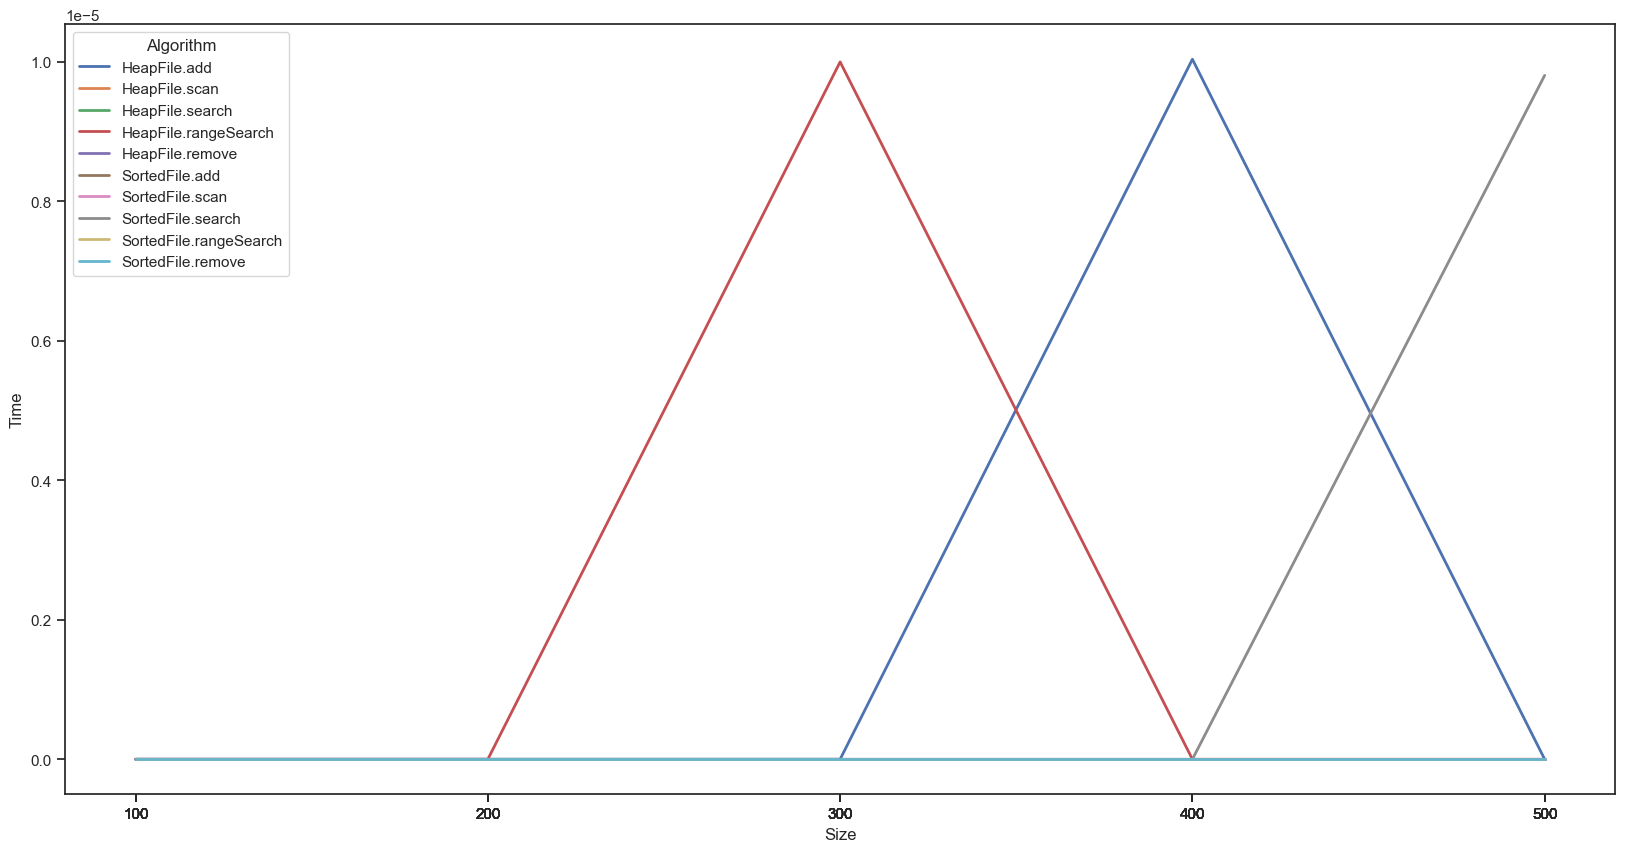

<Figure size 2000x1000 with 0 Axes>

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame.from_dict(mapSizeToTime, orient='index', columns=['Time'])
df['Algorithm'] = [i.split("##")[0] for i in df.index]
df['Size'] = [int(i.split("##")[1]) for i in df.index]
df

#Defines font size and line width
sns.set(font_scale=1, style="ticks", rc={"lines.linewidth": 2})

#Defines plot size
plt.rcParams['figure.figsize'] = [20, 10]

chart = sns.lineplot(x='Size', y='Time', hue='Algorithm', data=df)

#plt.yscale('log')
fig = plt.figure()
chart.set(xticks=[i for i in df.Size])
plt.show()

In [26]:
df

,Time,Algorithm,Size
HeapFile.add##100,0.00000,HeapFile.add,100
HeapFile.scan##100,0.00000,HeapFile.scan,100
HeapFile.search##100,0.00000,HeapFile.search,100
HeapFile.rangeSearch##100,0.00000,HeapFile.rangeSearch,100
HeapFile.remove##100,0.00000,HeapFile.remove,100
SortedFile.add##100,0.00000,SortedFile.add,100
SortedFile.scan##100,0.00000,SortedFile.scan,100
SortedFile.search##100,0.00000,SortedFile.search,100
SortedFile.rangeSearch##100,0.00000,SortedFile.rangeSearch,100
SortedFile.remove##100,0.00000,SortedFile.remove,100
